In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import folium

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (18.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 128285 files and dir

In [14]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

# 장소별 범죄율

## 데이터 불러오기

In [4]:
cbl_raw = pd.read_csv('/content/drive/MyDrive/강서구_빅데이터_공모전/cctv분석_동욱/5대범죄+발생장소별+현황_20230315001559.csv')
cbl = cbl_raw.copy()

## EDA

In [5]:
cbl = cbl[['장소별(2)', '범죄별(2)', '2021']]

In [6]:
cbl = cbl.rename(columns = {'장소별(2)':'loc', '범죄별(2)':'crime'})

In [7]:
cbl = cbl.query('crime == "소계"')

In [8]:
cbl = cbl.assign(ratio = cbl['2021'] / cbl['2021'][0]).drop([0, 78], axis = 0)
cbl = cbl.drop(['crime'], axis = 1)
cbl = cbl.sort_values(by = 'ratio', ascending = False)

## 시각화

In [18]:
plt.rcParams['font.family'] = 'NanumBarunGothic'

<Axes: xlabel='ratio', ylabel='loc'>

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from current font.
  func(*args, **kw

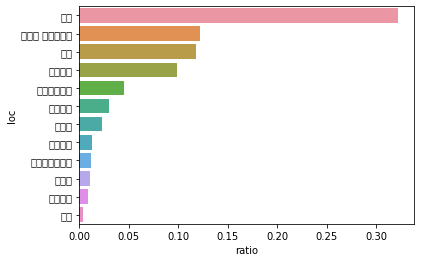

In [19]:
sns.barplot(data = cbl, x = 'ratio', y = 'loc')

# CCTV

## 데이터 불러오기

In [ ]:
ctv_raw = pd.read_csv('서울특별시 강서구_CCTV 시설물 정보_20201031.csv', encoding = 'CP949')

In [ ]:
ctv = ctv_raw.copy()

## 전처리

In [ ]:
ctv_full = ctv[['경도', '위도', '씨씨티브이방향각지원여부', '행정동분류명']]

In [ ]:
ctv_full.씨씨티브이방향각지원여부.value_counts()

### 결측치 처리

In [ ]:
#행정동 분류명이 있는 경우
ctv_code = ctv_full.dropna(subset=['행정동분류명']).dropna()
#행정동 분류명이 없는경우
ctv_dup = ctv_full[['경도', '위도', '씨씨티브이방향각지원여부']].dropna()

In [ ]:
ctv_dup.info()

### 열타입 변경

In [ ]:
ctv_code = ctv_code.astype({'행정동분류명':'int'})
ctv_code = ctv_code.astype({'행정동분류명':'str'})
ctv_code['행정동분류명'] = ctv_code['행정동분류명'].str.slice(start=0, stop=7)

### 열 이름 변경

In [ ]:
ctv_code = ctv_code.rename(columns = {'씨씨티브이방향각지원여부':'ctv_angle', '행정동분류명':'code'})
ctv_dup = ctv_dup.rename(columns = {'씨씨티브이방향각지원여부':'ctv_angle'})

### 라벨 인코딩

In [ ]:
ctv_code['ctv_angle'] = np.where(ctv_code['ctv_angle'] == 'Y', 1, 0)
ctv_dup['ctv_angle'] = np.where(ctv_dup['ctv_angle'] == 'Y', 1, 0)

In [ ]:
ctv_dup.ctv_angle.value_counts()

### 행정동 코드 있는 경우 최종 데이터

In [ ]:
ctv_code_final = ctv_code.groupby('code', as_index = False).agg(angle_count = ('ctv_angle', 'sum'))

## CCTV 중복된 지점을 찾는 경우

In [ ]:
ctv_dup_1 = ctv_dup.copy()

In [ ]:
ctv_dup_1

In [ ]:
ctv_dup_1['duplicated'] = ctv_dup_1.groupby(['경도', '위도'])['경도'].transform('size')

# 중복된 행 중 기능지원여부가 'Y'인 것이 있다면 최종 데이터프레임에서 'Y'로 해줌
# 그렇지 않으면 'N'으로 해줌
ctv_dup_1['ctv_angle'] = ctv_dup_1.groupby(['경도', '위도'])['ctv_angle'].transform(lambda x: 1 if 1 in x.values else 0)

# 중복 제거 후 최종 데이터프레임
ctv_dup_final = ctv_dup_1.drop_duplicates(subset=['경도', '위도'], keep='last')

ctv_dup_final.reset_index(drop=True, inplace=True)

In [ ]:
ctv_dup_final.value_counts()

### CCTV 중복 최종 데이터

In [ ]:
ctv_dup_single_no_angle = ctv_dup_final[(ctv_dup_final['ctv_angle'] == 0) & (ctv_dup_final['duplicated'] == 1)].reset_index(drop=True)
ctv_dup_single_angle = ctv_dup_final[(ctv_dup_final['ctv_angle'] == 1) & (ctv_dup_final['duplicated'] == 1)].reset_index(drop=True)
ctv_dup_multi_no_angle = ctv_dup_final[(ctv_dup_final['ctv_angle'] == 0) & (ctv_dup_final['duplicated'] != 1)].reset_index(drop=True)
ctv_dup_multi_angle = ctv_dup_final[(ctv_dup_final['ctv_angle'] == 1) & (ctv_dup_final['duplicated'] != 1)].reset_index(drop=True)

In [ ]:
print(len(ctv_dup_single_no_angle), len(ctv_dup_single_angle), len(ctv_dup_multi_no_angle), len(ctv_dup_multi_angle))

- 타깃이 수기라 변수간 상관관계 분석은 힘들듯..

## 시각화

### 행정동 코드가 없는 경우 

In [ ]:
kangseo_map1 = folium.Map(location = [37.56227, 126.81622], zoom_start = 13, tiles = 'Stamen Terrain')
kangseo_map2 = folium.Map(location = [37.56227, 126.81622], zoom_start = 13, tiles = 'Stamen Terrain')
kangseo_map3 = folium.Map(location = [37.56227, 126.81622], zoom_start = 13, tiles = 'Stamen Terrain')
kangseo_map4 = folium.Map(location = [37.56227, 126.81622], zoom_start = 13, tiles = 'Stamen Terrain')

In [ ]:
for i in range(len(ctv_dup_single_no_angle)):
    marker01 = folium.Marker([ctv_dup_single_no_angle.loc[i]['위도'], ctv_dup_single_no_angle.loc[i]['경도']],
                             icon = folium.Icon(color = 'red'),
                             icon_size = (3, 3))
    marker01.add_to(kangseo_map1)

   
kangseo_map1

In [ ]:
for i in range(len(ctv_dup_single_angle)):
    marker02 = folium.Marker([ctv_dup_single_angle.loc[i]['위도'], ctv_dup_single_angle.loc[i]['경도']],
                             icon = folium.Icon(color = 'orange'),
                             icon_size = (3, 3))
    marker02.add_to(kangseo_map2)
kangseo_map2

In [ ]:
for i in range(len(ctv_dup_multi_no_angle)):
    marker03 = folium.Marker([ctv_dup_multi_no_angle.loc[i]['위도'], ctv_dup_multi_no_angle.loc[i]['경도']],
                             icon = folium.Icon(color = 'lightgreen'),
                             icon_size = (3, 3))
    marker03.add_to(kangseo_map3)
kangseo_map3

In [ ]:
for i in range(len(ctv_dup_multi_angle)):
    marker04 = folium.Marker([ctv_dup_multi_angle.loc[i]['위도'], ctv_dup_multi_angle.loc[i]['경도']],
                             icon = folium.Icon(color = 'green'),
                             icon_size = (3, 3))
    marker04.add_to(kangseo_map4)
kangseo_map4

In [ ]:
cctv = pd.read_excel('12_04_08_E_CCTV정보.xlsx')
cctv.head()

In [ ]:
cctv = cctv[['소재지지번주소', 'WGS84위도', 'WGS84경도']]
cctv = cctv.rename(columns = {'소재지지번주소':'dong', 'WGS84위도':'위도', 'WGS84경도':'경도'})

In [ ]:
cctv

In [ ]:
cctv['행정동'] = cctv['dong'].str.split(' ').str[2]

In [ ]:
cctv['count'] = cctv.groupby('행정동')['행정동'].transform('count')

In [ ]:
cctv

In [ ]:
cctv_df = cctv.drop_duplicates(subset=['행정동'])

In [ ]:
cctv_df